# Basic Overview
This is a binary classification problem (there is no specification of the type of tumors or any other information) using brain MRI images that are provided in jpg format. 

We have an imbalanced dataset with:
* 155 images with tumors (61.3%)
* 98 images without tumors (38.7%)


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix
from PIL import Image
from typing import List, Tuple
from pathlib import Path

# Load Data From Kaggle

* This is just to ensure that we __only load image files__ and nothing else. 
* However, there __are more efficient ways__ to do this. Would like to know if any of you have any suggestions.

In [3]:
class BrainTumorDataset(Dataset):
    """
    Dataset class to load the Brain MRI Images from the 'kaggle/input' folder.
    """
    def __init__(self, base_dir: str, transform=None):
        """
        Initialize the dataset with support for the varying file extensions of jpeg and a few png files.  
        
        Args:
            base_dir (str): Base directory path containing 'yes' and 'no' subdirectories
            transform (callable, optional): Transform to be applied to images
        """
        self.base_dir = Path(base_dir)
        self.transform = transform
        self.valid_extensions = ('.jpg', '.jpeg', '.png', '.JPG')
        
        # Initialize lists to store paths and labels
        self.data: List[Tuple[str, int]] = []
        self.class_counts = {'yes': 0, 'no': 0}
        
        # Load and validate images
        self._load_dataset()
        
    def _load_dataset(self):
        """
        Load dataset while handling multiple image formats and performing basic validation
        """
        # Load tumor images (label 1)
        tumor_dir = self.base_dir / 'yes'
        for ext in self.valid_extensions:
            tumor_images = list(tumor_dir.glob(f'*{ext}'))
            for img_path in tumor_images:
                try:
                    # Validate image can be opened
                    with Image.open(img_path) as img:
                        img.verify()  # Verify image is not corrupted
                    self.data.append((str(img_path), 1))
                    self.class_counts['yes'] += 1
                except (IOError, SyntaxError) as e:
                    print(f"Warning: Skipping corrupted image {img_path}: {e}")
            
        # Load non-tumor images (label 0)
        no_tumor_dir = self.base_dir / 'no'
        for ext in self.valid_extensions:
            no_tumor_images = list(no_tumor_dir.glob(f'*{ext}'))
            for img_path in no_tumor_images:
                try:
                    # Validate image can be opened i.e., not corrupted
                    with Image.open(img_path) as img:
                        img.verify()  
                    self.data.append((str(img_path), 0))
                    self.class_counts['no'] += 1
                except (IOError, SyntaxError) as e:
                    print(f"Warning: Skipping corrupted image {img_path}: {e}")
        
        # Convert to numpy array for faster indexing
        self.data = np.array(self.data)
        
        # Print dataset statistics
        print(f"Dataset loaded successfully:")
        print(f"Total images: {len(self.data)}")
        print(f"Tumor images: {self.class_counts['yes']}")
        print(f"Non-tumor images: {self.class_counts['no']}")
        
    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        labels = int(label)
        
        if self.transform:
            image = self.transform(image)
    
        return image, labels

Dataset loaded successfully:
Total images: 253
Tumor images: 155
Non-tumor images: 98


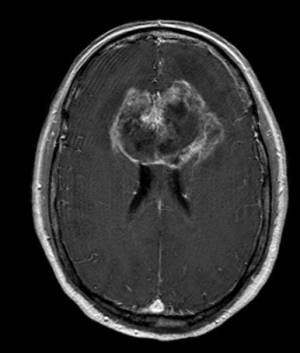

In [4]:
ds = BrainTumorDataset(base_dir="../input/brain-mri-images-for-brain-tumor-detection")
Image.open(ds.data[78][0]).convert('RGB')


# Data Augmentation and Preprocessing

In [5]:
def mri_image_normalizations(dataset_dir, batch_size=32, num_workers=2):

    
     # Create temporary transform that only converts to tensor
    temp_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()  # This scales values to [0, 1]
    ])
    # Create dataset with minimal transform
    dataset = BrainTumorDataset(dataset_dir, transform=temp_transform)
    loader = DataLoader(dataset, batch_size, num_workers)

    
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total_samples = 0
    
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        total_samples += batch_samples
    
    mean = mean / total_samples
    
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        std += ((images - mean.view(1, -1, 1))**2).mean(2).sum(0)
    
    std = torch.sqrt(std / total_samples)
    
    return mean.tolist(), std.tolist()

mri_means, mri_stds = mri_image_normalizations(dataset_dir="../input/brain-mri-images-for-brain-tumor-detection")
mri_means, mri_stds

Dataset loaded successfully:
Total images: 253
Tumor images: 155
Non-tumor images: 98


([0.24824212491512299, 0.24848966300487518, 0.24857774376869202],
 [0.2386155128479004, 0.2388613522052765, 0.23906360566616058])

In [15]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(43), 
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(
        degrees=0,
        shear=15,  # Mild shear transformation
        fill=0
    ),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Contrast adjustment
    transforms.ToTensor(),
    transforms.Normalize(mean=mri_means, std=mri_stds),
    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.02)  # Gaussian noise
])


test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mri_means, std=mri_stds)
])

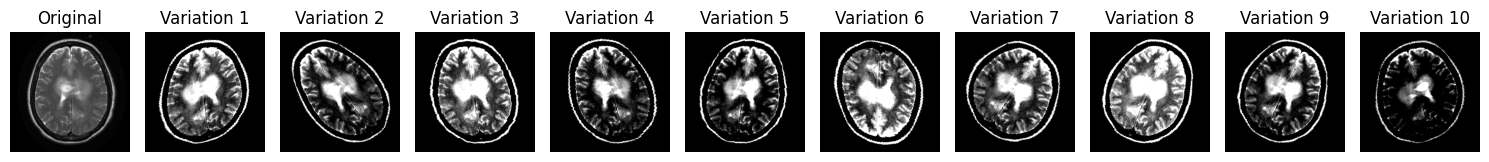

In [7]:
# Load single image
img = Image.open(ds.data[1][0])

# Sample number of variations
num_variations = 10

# Create multiple variations
fig, axes = plt.subplots(1, num_variations + 1, figsize=(15, 3))

# Show original
axes[0].imshow(img)
axes[0].set_title('Original')
axes[0].axis('off')

# Show variations
for i in range(num_variations):
    # Apply augmentation
    augmented = train_transform(img)

    # Display
    axes[i + 1].imshow(augmented.permute(1, 2, 0))
    axes[i + 1].set_title(f'Variation {i+1}')
    axes[i + 1].axis('off')

plt.tight_layout()
plt.show()

## Function to verify dataset integrity

The reason I wrote this function was because I overlooked some file that had a '.JPG' extension. I was not getting the right number of images in each folder.

They all refer to the same jpeg format, from legacy systems, but need to be specified appropriately when loading in code.

In [ ]:
# def verify_dataset(base_dir: str) -> None:
#     """
#     Verify the integrity of the dataset and print detailed statistics
    
#     Args:
#         base_dir (str): Base directory containing the dataset
#     """
#     dataset = BrainTumorDataset(base_dir)
    
#     # Verify all images can be loaded
#     print("\nVerifying image loading...")
#     corrupted_images = []
#     for idx in range(len(dataset)):
#         try:
#             image, label = dataset[idx]
#         except Exception as e:
#             corrupted_images.append((dataset.data[idx][0], str(e)))
    
#     if corrupted_images:
#         print("\nWarning: Found corrupted images:")
#         for path, error in corrupted_images:
#             print(f"- {path}: {error}")
#     else:
#         print("All images verified successfully!")


# verify_dataset(base_dir="/kaggle/input/brain-mri-images-for-brain-tumor-detection")

# Model Building

In [12]:
class TumorClassifier(nn.Module):
    """ResNet50-based tumor classifier with custom head"""
    def __init__(self, num_classes=1):
        super(TumorClassifier, self).__init__()
        # Load pretrained ResNet50
        self.mri_classifier = models.resnet50(pretrained=True)
        
        # Freeze early layers
        for param in list(self.mri_classifier.parameters())[:-6]:
            param.requires_grad = False
            
        # Modify the final layer for binary classification
        num_features = self.mri_classifier.fc.in_features
        self.mri_classifier.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
            # nn.Sigmoid()
        )

    def forward(self, x):
        return self.mri_classifier(x)

# Model Training

In [20]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, device='cuda'):
    """
    Train the model with early stopping and learning rate scheduling
    Returns training history for plotting
    """
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'best_model': None,
        'best_epoch': 0,
        'best_val_loss': float('inf')
    }

    
    
    patience = 10
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            
            inputs, labels = inputs.to(device), labels.to(device).float()
            
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = train_loss / len(train_loader)
        train_acc = correct / total
        
        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = correct / total
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        # Early stopping check
        if val_loss < history['best_val_loss']:
            history['best_val_loss'] = val_loss
            history['best_model'] = model.state_dict().copy()
            history['best_epoch'] = epoch
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break
            
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    return history

def evaluate_model(model, test_loader, device='cuda'):
    """
    Evaluate the model and return detailed metrics
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            probs = outputs.cpu().numpy()
            preds = (outputs > 0.5).float().cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)
    
    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary'
    )
    auc_roc = roc_auc_score(all_labels, all_probs)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc_roc': auc_roc,
        'conf_matrix': conf_matrix
    }

def plot_training_history(history):
    """
    Plot training and validation metrics
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Accuracy plot
    ax2.plot(history['train_acc'], label='Training Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_title('Accuracy Over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    return fig

def plot_confusion_matrix(conf_matrix):
    """
    Plot confusion matrix heatmap
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix, 
        annot=True, 
        fmt='d',
        cmap='Blues',
        xticklabels=['No Tumor', 'Tumor'],
        yticklabels=['No Tumor', 'Tumor']
    )
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    return plt.gcf()

Dataset loaded successfully:
Total images: 253
Tumor images: 155
Non-tumor images: 98


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30:
Train Loss: 0.4808, Train Acc: 0.4000
Val Loss: 0.4551, Val Acc: 0.3478
Epoch 2/30:
Train Loss: 0.4539, Train Acc: 0.4000
Val Loss: 0.4113, Val Acc: 0.3478
Epoch 3/30:
Train Loss: 0.4277, Train Acc: 0.4878
Val Loss: 0.3752, Val Acc: 0.3913
Epoch 4/30:
Train Loss: 0.4071, Train Acc: 0.4927
Val Loss: 0.3427, Val Acc: 0.3478
Epoch 5/30:
Train Loss: 0.3546, Train Acc: 0.6293
Val Loss: 0.2986, Val Acc: 0.5652
Epoch 6/30:
Train Loss: 0.3220, Train Acc: 0.6390
Val Loss: 0.2005, Val Acc: 0.8696
Epoch 7/30:
Train Loss: 0.3015, Train Acc: 0.7854
Val Loss: 0.1790, Val Acc: 0.8261
Epoch 8/30:
Train Loss: 0.2727, Train Acc: 0.7268
Val Loss: 0.1557, Val Acc: 0.8696
Epoch 9/30:
Train Loss: 0.2686, Train Acc: 0.8098
Val Loss: 0.2119, Val Acc: 0.8696
Epoch 10/30:
Train Loss: 0.2346, Train Acc: 0.7707
Val Loss: 0.1926, Val Acc: 0.9130
Epoch 11/30:
Train Loss: 0.2234, Train Acc: 0.8293
Val Loss: 0.1878, Val Acc: 0.7826
Epoch 12/30:
Train Loss: 0.2244, Train Acc: 0.8098
Val Loss: 0.1974, Val A

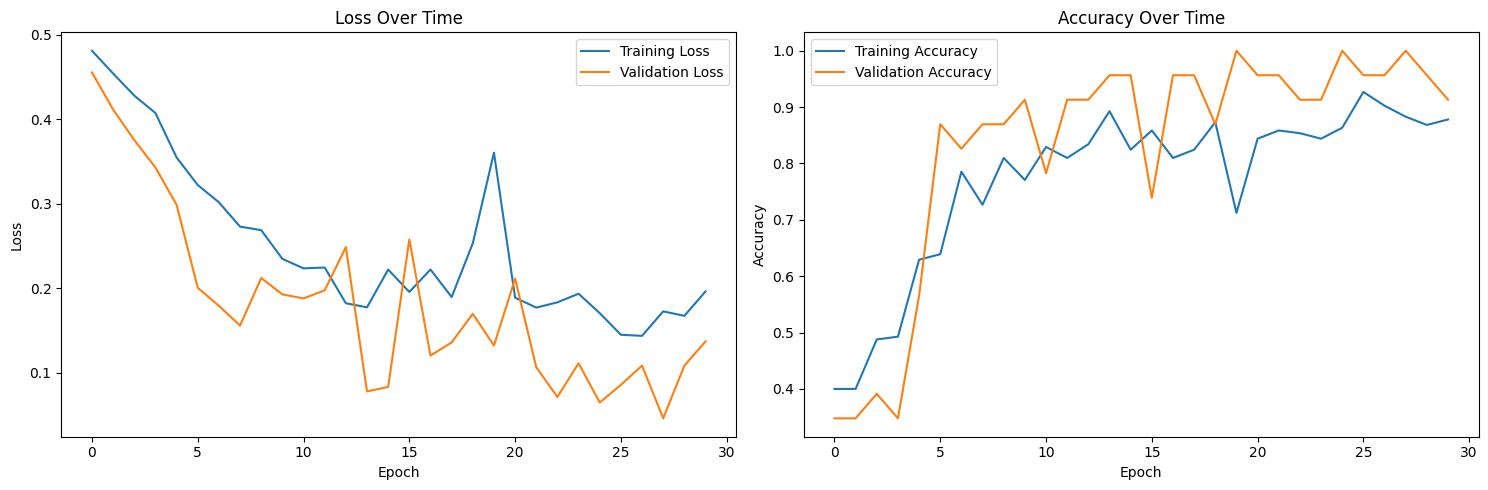

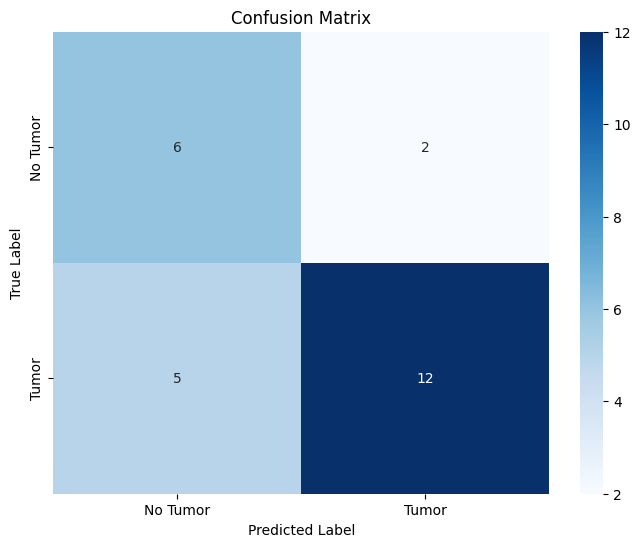

In [22]:
# Main execution block
def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Create datasets and dataloaders
    full_dataset = BrainTumorDataset("/kaggle/input/brain-mri-images-for-brain-tumor-detection/", transform=train_transform)
        
        # First split: training vs test (90/10)
    total_size = len(full_dataset)
    test_size = int(0.1 * total_size)
    train_val_size = total_size - test_size
    
    train_val_dataset, test_dataset = torch.utils.data.random_split(
        full_dataset, [train_val_size, test_size]
    )
    
    # Second split: train vs validation (90/10 of training data)
    train_size = int(0.9 * len(train_val_dataset))
    val_size = len(train_val_dataset) - train_size
    
    train_dataset, val_dataset = torch.utils.data.random_split(
        train_val_dataset, [train_size, val_size]
    )
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    test_loader = DataLoader(test_dataset, batch_size=32)
    
    # Initialize model
    model = TumorClassifier().to(device)
    
    # Calculate class weights by accessing the original dataset correctly
    original_dataset = train_dataset.dataset.dataset  # Access the original dataset through nested subsets
    train_indices = [train_dataset.indices[i] for i in range(len(train_dataset))]
    train_labels = [int(original_dataset.data[idx][1]) for idx in train_indices]
    
    num_pos = sum(train_labels)
    num_neg = len(train_labels) - num_pos
    pos_weight = torch.tensor([num_neg / num_pos]).to(device)
    
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=5, verbose=True
    )
    
    # Train model
    history = train_model(
        model, train_loader, val_loader,
        criterion, optimizer, scheduler
    )
    
    # Load best model and evaluate
    model.load_state_dict(history['best_model'])
    metrics = evaluate_model(model, test_loader)
    
    # Plot results
    plot_training_history(history)
    plot_confusion_matrix(metrics['conf_matrix'])

     # Print test set metrics
    print("\nTest Set Metrics:")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print(f"ROC AUC Score: {metrics['auc_roc']:.4f}")
    
    # Print confusion matrix in text form for clarity
    print("\nConfusion Matrix:")
    print("                 Predicted No Tumor  Predicted Tumor")
    print(f"Actual No Tumor      {metrics['conf_matrix'][0][0]}                {metrics['conf_matrix'][0][1]}")
    print(f"Actual Tumor         {metrics['conf_matrix'][1][0]}                {metrics['conf_matrix'][1][1]}")
    
    
    return model, history, metrics

if __name__ == '__main__':
    model, history, metrics = main()

## Saving (Private) Model ;)

In [23]:
# Save the complete model
torch.save(model, 'BrainTumor_resnet50_BClassifier.pth')

# To load this type of saved model:
# loaded_model = torch.load('complete_brain_tumor_model.pth')



# You could also save only the model state dictionary
# torch.save(model.state_dict(), 'brain_tumor_model_weights.pth')

# To load these weights, you would first initialize your model structure:
# model = TumorClassifier() # Make your required changes to the Class
# model.load_state_dict(torch.load('brain_tumor_model_weights.pth'))

# Discussion

The results reveal both strengths and areas for improvement in the model's tumor detection capabilities. With a precision of 0.8571, when the model predicts a tumor is present, it is correct about 86% of the time. This high precision is particularly important in medical diagnostics, as it indicates a relatively low rate of false positives – situations where the model incorrectly suggests a tumor is present when it isn't.

However, the recall value of 0.7059 indicates that the model identifies about 71% of actual tumors present in the images. This means it misses approximately 29% of tumors, which is reflected in the confusion matrix showing 5 false negatives. In a medical context, these missed detections (false negatives) are particularly concerning as they could lead to delayed treatment.

The F1 score of 0.7742 provides a balanced measure between precision and recall. This score suggests that while the model performs reasonably well, there is room for improvement in balancing the trade-off between false positives and false negatives. The ROC_AUC score of 0.7721 indicates that the model has good discriminative ability, showing it can distinguish between tumor and non-tumor cases better than random chance (0.5) but falls short of excellent performance (> 0.9).

Looking at the confusion matrix in detail:

* True Negatives (6): The model correctly identified 6 cases without tumors
* False Positives (2): The model incorrectly flagged 2 healthy cases as having tumors
* False Negatives (5): The model missed 5 cases where tumors were actually present
* True Positives (12): The model correctly identified 12 cases with tumors

These results suggest that while the model shows promise, it tends to be more conservative in its tumor predictions. The higher precision compared to recall indicates it prioritizes avoiding false alarms over catching all potential tumors. For a medical screening tool, we might want to adjust this balance to favor higher recall, even at the cost of some precision, as missing a tumor (false negative) is generally more serious than a false alarm that can be ruled out by further testing.